In [6]:
import glob
from pathlib import Path
from preprocessing import preprocessing
from predict import predict
import pandas as pd
import wave
from pydub import AudioSegment
import os
import re
import pandas as pd
# read audio file
from pydub import AudioSegment
import librosa
import os
import numpy as np
import librosa.display
import csv
from scipy.signal import savgol_filter
from scipy import signal
import matplotlib.pyplot as plt
# print os.environ['PATH']

In [7]:
def makeDirIfNotExist(path):
# path = "pythonprog"
# Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:
       # Create a new directory because it does not exist
       os.makedirs(path)
       print("The new directory is created!")

In [8]:
# input files
inputFolder = "input/2min/"
preprocessedFolder = inputFolder.replace('input','preprocessed')
outputFolder = inputFolder.replace('input','output')

In [9]:
# Make output folder if it does not exist.
makeDirIfNotExist(preprocessedFolder)
makeDirIfNotExist(outputFolder)
audioFiles = glob.glob("input/2min/*.wav")

In [10]:
# audio_filename = audioFiles[0]
audio_filename = '/Users/jimmy/data/LENA/1198_LENA/AN1/segmented_2min/0.wav'
i = 0

In [11]:
 # Determine file names
fileNumber = int(re.findall(r'\d+', audio_filename.split("/")[-1])[0])
preprocesedFile = preprocessedFolder + str(fileNumber) + '.csv'
predictFile = outputFolder + str(fileNumber) + '.csv'
labelFile = inputFolder + str(fileNumber) + '_label.csv'

In [12]:
# Preproecessing
# preprocessing(audioFile,preprocesedFile)

In [44]:
from preprocessing import whatIsAnEvent,combineIntoEvent

In [50]:
##Hyperparameters
n_fft = 1764
hop_length = 882
n_mels = 128

In [58]:
y, sr = librosa.load(audio_filename)
duration = librosa.get_duration(y=y, sr=sr)

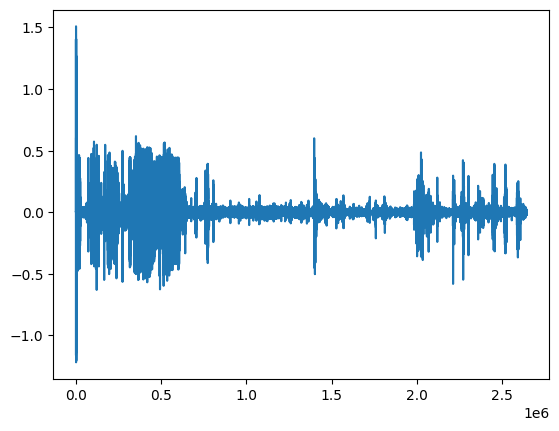

In [59]:
plt.plot(y)

In [60]:
sos = signal.butter(100, 400, 'hp', fs=sr, output='sos')
y  = signal.sosfilt(sos, y)
# We'll need IPython.display's Audio widget
from IPython.display import Audio
Audio(data=y, rate=sr)

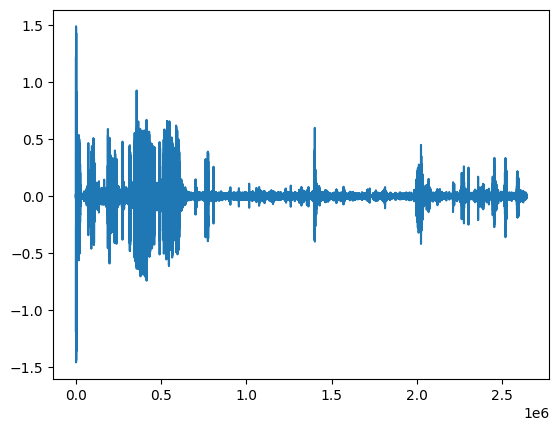

In [61]:
plt.plot(y)

In [29]:
##spectrogram gives the power of signals higher than 350Hz at each time point
S = librosa.feature.melspectrogram(y = y, sr = sr, n_mels = n_mels, fmax=None, n_fft = n_fft, hop_length = hop_length)
S_dB = librosa.power_to_db(S, ref = np.max)

In [30]:
##noise reduction
S[np.where(S_dB < -78)] = 0

In [19]:
##Sum of power of all frequencies (higher than 350Hz) at each time point
S_sum = np.transpose(np.sum(S, axis = 0))

In [20]:
##smoothing
if len(S_sum) >= 121:
    filted = savgol_filter(S_sum, 121, 5)
else:
    filted = savgol_filter(S_sum, len(S_sum), 3)

In [21]:
##1 for those have sum of power of all frequencies (higher than 350Hz) larger than 5, 0 otherwise
filted = np.asarray([1 if x > 5 else 0 for x in filted])
# plt.plot(filted)

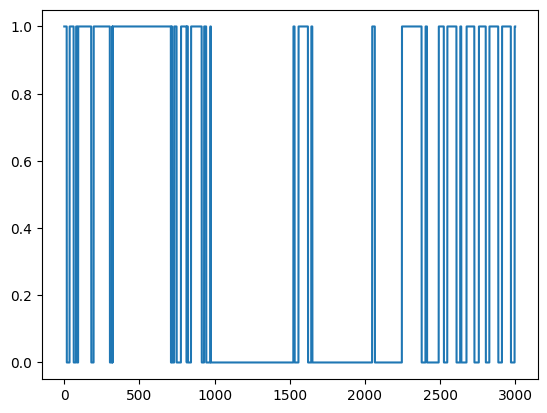

In [22]:
plt.plot(filted)

In [23]:
##Time column ([1, 0, 1, 1, 1, ...]->[[0, 1], [1, 0], [2, 1], [3, 1], [4, 1], ...])
timed_filted = np.stack([np.arange(len(filted)), filted], axis = 1)

##Combine neighbouring 1s within 5 seconds of each other
timed_filted = combineIntoEvent(timed_filted, 5 / (hop_length * 1. /sr))
##Remove isolated 1s shorter than 5 seconds
timed_filted = whatIsAnEvent(timed_filted, 5 / (hop_length * 1. /sr))

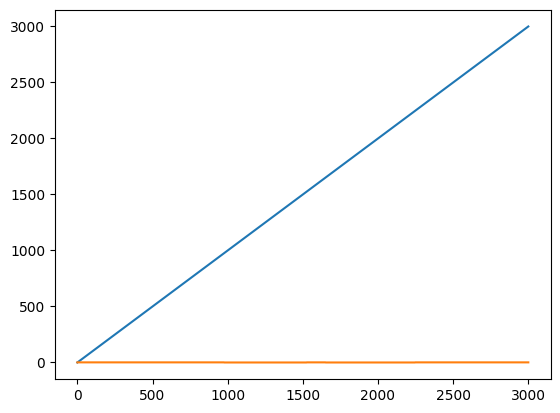

In [24]:
plt.plot(timed_filted)

In [84]:
##change the timestamp from frame number to seconds
##for all frames within a second, if there is a 1, then the second is 0, otherwise 0
##predictions is a list of 1/0 with length equal to the length of audio file in seconds
predictions = []
pointer = 1
temp = []

In [85]:
temp = []
for ind, value in enumerate(np.arange(0, duration + hop_length * 1. / sr, hop_length * 1. / sr)):
    if ind < len(timed_filted):
        if value < pointer:
            temp.append(timed_filted[ind, 1])
        else:
            if sum(temp) > 0:
                predictions.append(1)
            else:
                predictions.append(0)
            temp = [timed_filted[ind, 1]]
            pointer += 1

In [86]:
##convert predictions to output
##predictions is a list of 1/0 with length equal to the length of audio file in seconds [1, 0, 1, 1, 1, ...]
##output is the start_time and end_time of continous 1s [[0, 1], [2, 5], ...]
begin = False
start_time = 0
output = []
for ind, item in enumerate(predictions):
    if item == 1:
        if not begin:
            start_time = ind
            begin = True
    else:
        if begin:
            output.append([start_time, ind])
            begin = False
if begin:
    output.append([start_time, len(predictions)])


##write output into a file
print(output)
with open(preprocesedFile, 'w', newline = '') as f:
    writer = csv.writer(f)
    writer.writerows(output)

[[0, 12], [20, 50], [68, 120]]


In [87]:
# Prediction
# predict(audio_filename, preprocesedFile, predictFile)

In [88]:
from predict import whatIsAnEvent,combineIntoEvent
from tensorflow.keras.models import Sequential, model_from_json, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K

In [89]:
##hyperparameters
n_fft = 980
hop_length = 490
n_mels = 225
img_rows, img_cols = 225, 225
batch_size = 128
num_classes = 2

In [90]:
saved_model1 = load_model('deep_spectrum.h5')
model1 = Sequential()
for layer in saved_model1.layers[:-1]:
    model1.add(layer)

for layer in model1.layers:
    layer.trainable = False

In [91]:
#load svm model, svm model is at the same repository
from joblib import dump, load
clf1 = load('svm.joblib')

/Users/jimmy/venv-metal/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SVC from version 0.23.0 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [92]:
##read audio file
y, sr = librosa.load(audio_filename, offset = 0)
duration = librosa.get_duration(y = y, sr = sr)

In [93]:
previous = 0
filtered_annotations = []
with open(preprocesedFile, 'r') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    for row in csvreader:
        if float(row[0]) - previous > 0:
            filtered_annotations.extend([0] * int(float(row[0]) - previous))
        previous = float(row[1])
        filtered_annotations.extend([1] * int(float(row[1]) - float(row[0])))
if duration - previous > 0:
    filtered_annotations.extend([0] * int(duration - previous))

In [94]:
##windowing, 5 second windows with 4 second overlap
##windows = [[0, 5], [1, 6], [2, 7], ...]
windows = []
for i in range(0, int(duration) - 4):
    windows.append([i, i + 5])

In [95]:
##Features extraction to get melspectrograms and all acoustic features from pyAudioAnalysis
from pyAudioAnalysis import ShortTermFeatures
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=None, n_fft = n_fft, hop_length = hop_length)
S = librosa.power_to_db(S, ref=np.max) + 80
F, _ = ShortTermFeatures.feature_extraction(y, sr, 1 * sr, 0.5 * sr)
F = F[:, 0::2]

In [96]:
##image_windows contain melspectrograms for each 5-second window
##feature_windows contain acoustic features (mean, median, std) for each 5-second window
image_windows = []
feature_windows = []
for item in windows:
    image_windows.append(S[:, int(item[0] * sr / hop_length) : int(item[1] * sr / hop_length)])
    F_window = F[:, item[0] : item[1]]
    F_feature = np.concatenate((np.mean(F_window, axis = 1), np.median(F_window, axis = 1), np.std(F_window, axis = 1)), axis = None)
    feature_windows.append(F_feature)

In [97]:
##preprocess before put 5-second melspectrograms into deep spectrum (AlexNet) model
image_windows = np.asarray(image_windows)
image_windows = image_windows.reshape(image_windows.shape[0], img_rows, img_cols, 1)
image_windows = image_windows.astype('float32')
image_windows /= 80.0

In [98]:
##image_features is deep spectrum features from the model with melspectrograms as input
image_features = model1.predict(image_windows, batch_size=batch_size, verbose=1, steps=None)
##concatenate deep spectrum features and acoustic features and make a prediction using trained SVM model
##the prediction is for each 5 second windows with 4 second overlap
svm_test_input = np.concatenate((image_features, feature_windows), axis = 1)
predictions = clf1.predict(svm_test_input)

1/1 [==============================] - 0s 163ms/step


2023-01-26 09:49:02.739350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [99]:
##using preprocessed file to filter the predictions
##only consider those seconds with power for frequencies higher than 350Hz
##each second can be predicted 5 times because of the window overlap, if it's predicted as crying for at least one time, then it's crying (1), otherwise it's not
for ind, val in enumerate(filtered_annotations):
    if val >= 1:
        min_ind = max(ind - 4, 0)
        max_ind = min(len(predictions), ind + 1)
        if sum(predictions[min_ind : max_ind]) >= 1:
            filtered_annotations[ind] = 1
        else:
            filtered_annotations[ind] = 0

In [100]:
##add a timestamp for predictions
timed_filted = np.stack([np.arange(len(filtered_annotations)), filtered_annotations], axis = 1)
##Combine neighbouring crying(1s) within 5 seconds of each other
timed_filted = combineIntoEvent(timed_filted, 5)
##Remove isolated 1s shorter than 5 seconds
timed_filted = whatIsAnEvent(timed_filted, 5)

In [101]:
##write predictions into a file
outResult = timed_filted.copy()
print(outResult)
if output_file != None:
    with open(output_file, 'w', newline = '') as f:
        writer = csv.writer(f)
        writer.writerows(timed_filted)

[[  0   1]
 [  1   1]
 [  2   1]
 [  3   1]
 [  4   1]
 [  5   1]
 [  6   1]
 [  7   1]
 [  8   1]
 [  9   1]
 [ 10   1]
 [ 11   1]
 [ 12   0]
 [ 13   0]
 [ 14   0]
 [ 15   0]
 [ 16   0]
 [ 17   0]
 [ 18   0]
 [ 19   0]
 [ 20   0]
 [ 21   0]
 [ 22   0]
 [ 23   0]
 [ 24   1]
 [ 25   1]
 [ 26   1]
 [ 27   1]
 [ 28   1]
 [ 29   1]
 [ 30   1]
 [ 31   1]
 [ 32   1]
 [ 33   1]
 [ 34   1]
 [ 35   1]
 [ 36   1]
 [ 37   1]
 [ 38   1]
 [ 39   1]
 [ 40   1]
 [ 41   1]
 [ 42   1]
 [ 43   1]
 [ 44   1]
 [ 45   1]
 [ 46   1]
 [ 47   1]
 [ 48   0]
 [ 49   0]
 [ 50   0]
 [ 51   0]
 [ 52   0]
 [ 53   0]
 [ 54   0]
 [ 55   0]
 [ 56   0]
 [ 57   0]
 [ 58   0]
 [ 59   0]
 [ 60   0]
 [ 61   0]
 [ 62   0]
 [ 63   0]
 [ 64   0]
 [ 65   0]
 [ 66   0]
 [ 67   0]
 [ 68   1]
 [ 69   1]
 [ 70   1]
 [ 71   1]
 [ 72   1]
 [ 73   1]
 [ 74   1]
 [ 75   1]
 [ 76   1]
 [ 77   1]
 [ 78   1]
 [ 79   1]
 [ 80   1]
 [ 81   1]
 [ 82   1]
 [ 83   1]
 [ 84   1]
 [ 85   1]
 [ 86   1]
 [ 87   1]
 [ 88   1]
 [ 89   1]
 [ 90   1]

NameError: name 'output_file' is not defined